In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime
from scipy import stats
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math 
import warnings
warnings.filterwarnings('ignore')
import itertools

### Load Data 

In [2]:
#Customer Volumes data
customer_volumes = pd.read_excel('Data Challenge.xlsx', sheet_name='Customer Historical Volumes', engine='openpyxl')
#Cleaning the dates column
customer_volumes['Month'] = pd.to_datetime(customer_volumes['Month'], format='%Y%m')
print('historical_customer_volumes from {} to {}'.format(customer_volumes['Month'].min(), customer_volumes['Month'].max()))

historical_customer_volumes from 2011-01-01 00:00:00 to 2019-03-01 00:00:00


In [3]:
#Indexes Data
indexes = pd.read_excel('Data Challenge.xlsx', sheet_name='Indexes', engine='openpyxl').dropna(how='all', axis='columns')
#Cleaning the dates column
indexes['Month'] = pd.to_datetime(indexes['Month'], format='%Y%m')
print('indexes data from {} to {}'.format(indexes['Month'].min(), indexes['Month'].max()))

indexes data from 2011-01-01 00:00:00 to 2020-09-01 00:00:00


In [4]:
#Merge Data
df = pd.concat([customer_volumes,indexes],axis=1).dropna()
df = df.loc[:,~df.columns.duplicated()]
df = df.set_index('Month')
df = df[['Customer Volumes','IDX1','IDX2','IDX3']]

### Quick Visualization

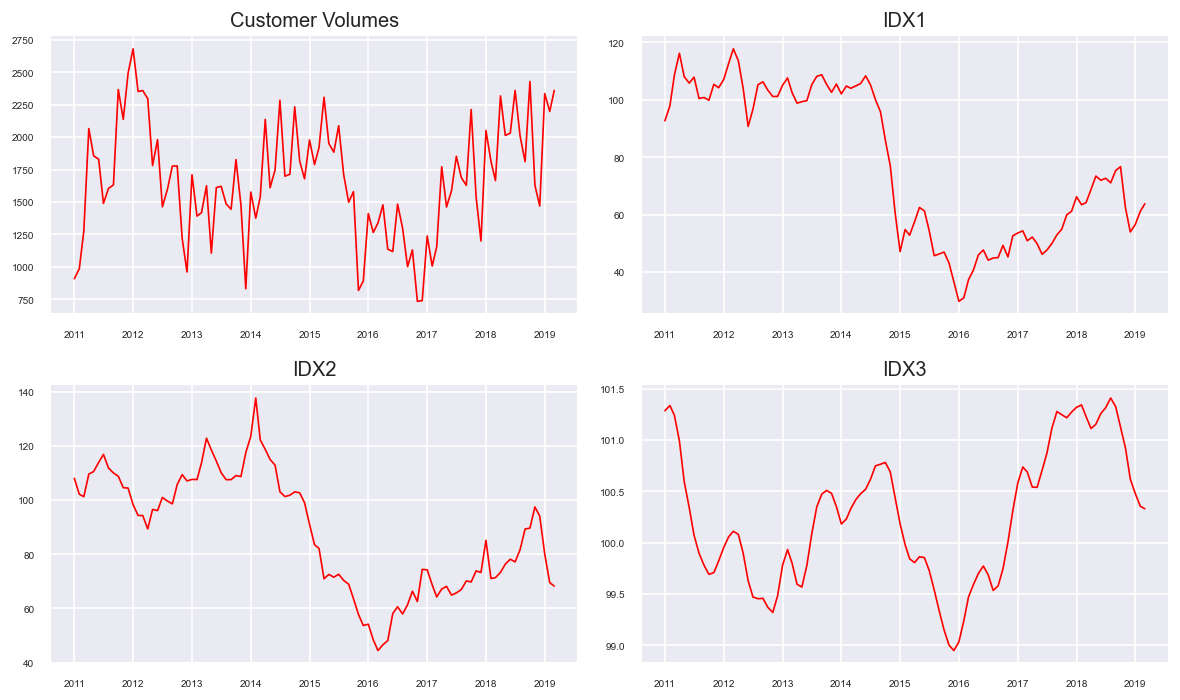

In [5]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

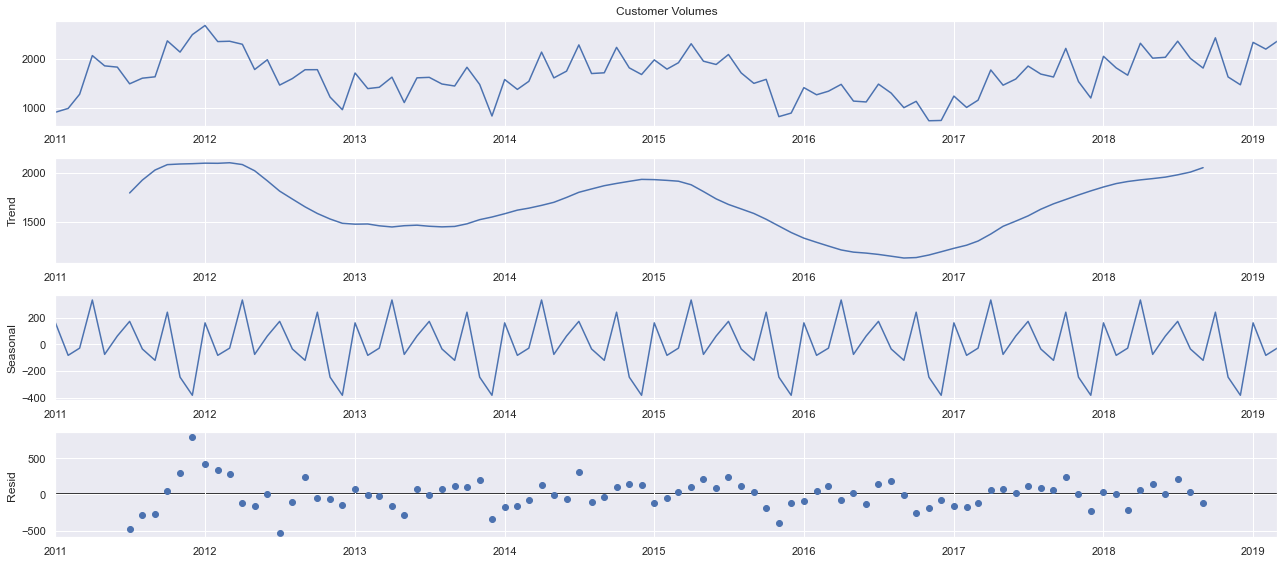

In [6]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df['Customer Volumes'], model='additive')
fig = decomposition.plot()
plt.show()

* The plot above clearly shows that the customer volumes is unstable, along with its obvious seasonality.

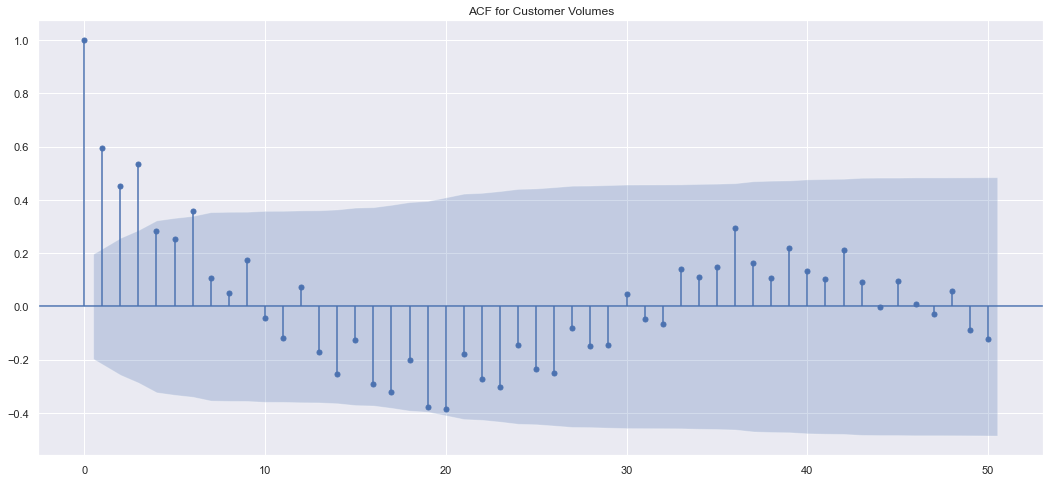

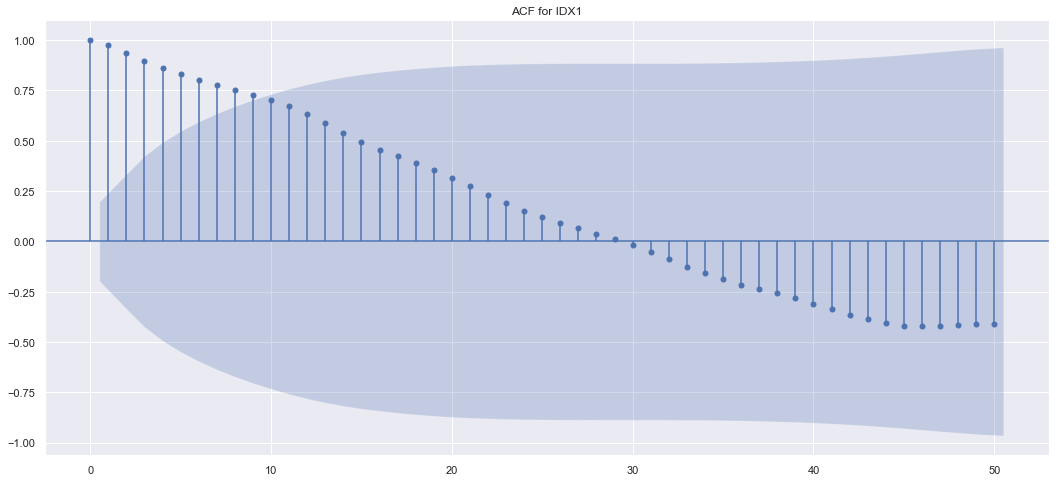

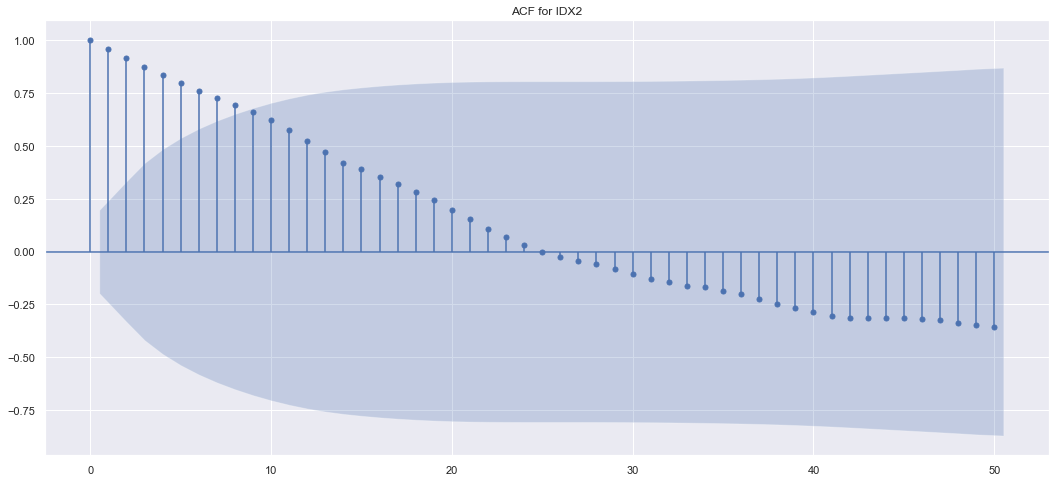

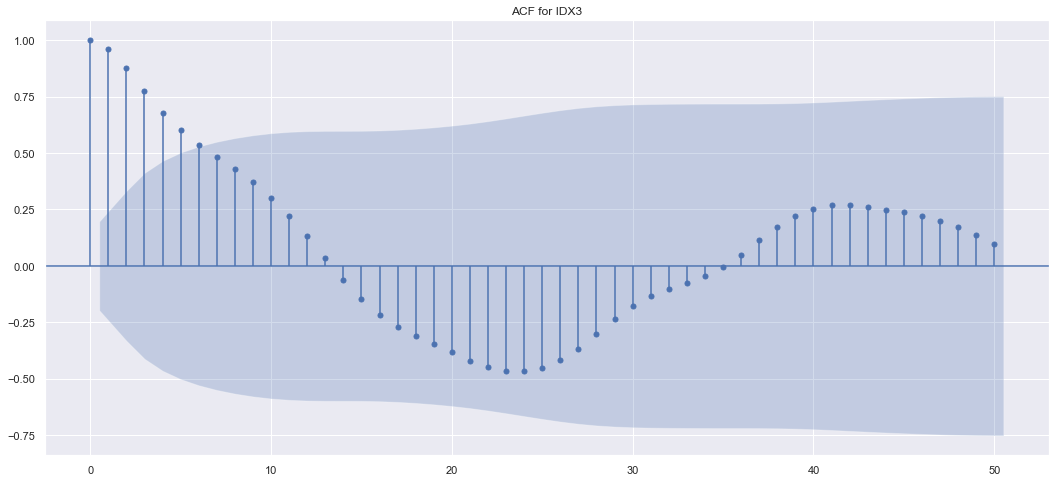

In [7]:
# plots the autocorrelation plots for each indexes at 50 lags
for i in df:
    plot_acf(df[i], lags = 50)
    plt.title('ACF for %s' % i)
    plt.show()

In [8]:
def DoLinePlot_wVLines():
    #df = df.loc[df['Date'] >= StartYear].copy()
    data = df[[Series1,Series2]]
    #data = data.set_index('Date').resample('Q').mean()
    sns.set(font_scale=1.5)
    x = data.index
    y = data[Series1]
    y1 = data[Series2]
    fig, ax1 = plt.subplots(figsize = (15,7.5))
    ax2 = ax1.twinx()
    ax1.plot(x, y)
    ax2.plot(x, y1, color="red" )
    ax1.set_xlabel('Dateline')
    ax1.set_ylabel(Series1, color='b')
    ax2.set_ylabel(Series2, color='r')
    fig.autofmt_xdate()
 
    # plot inflection points
    plt.axvline(x = datetime.fromisoformat("2012-01-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2013-12-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-04-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2016-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2018-10-01"), color='g')
    
    plt.show()

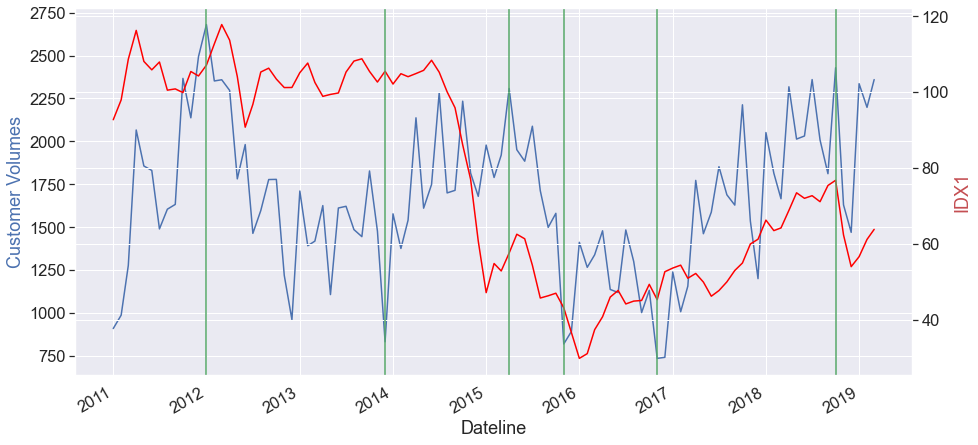

In [9]:
Series1 = "Customer Volumes"
Series2 = "IDX1"
DoLinePlot_wVLines()

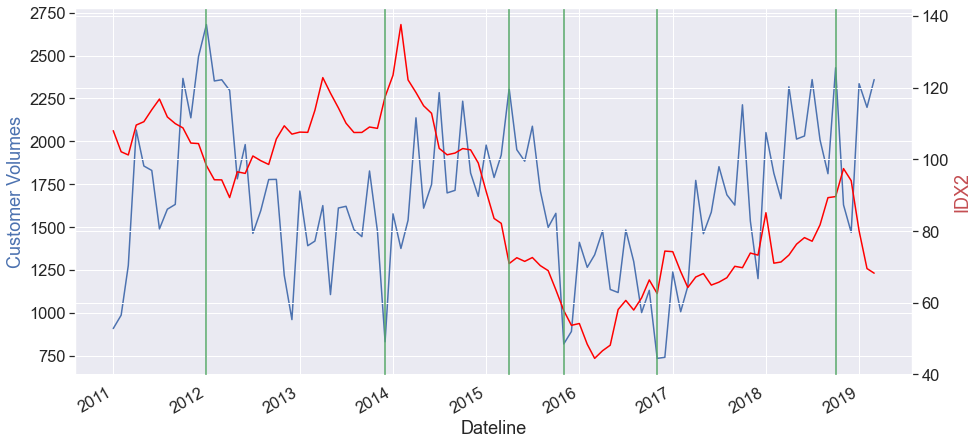

In [10]:
Series1 = "Customer Volumes"
Series2 = "IDX2"
DoLinePlot_wVLines()

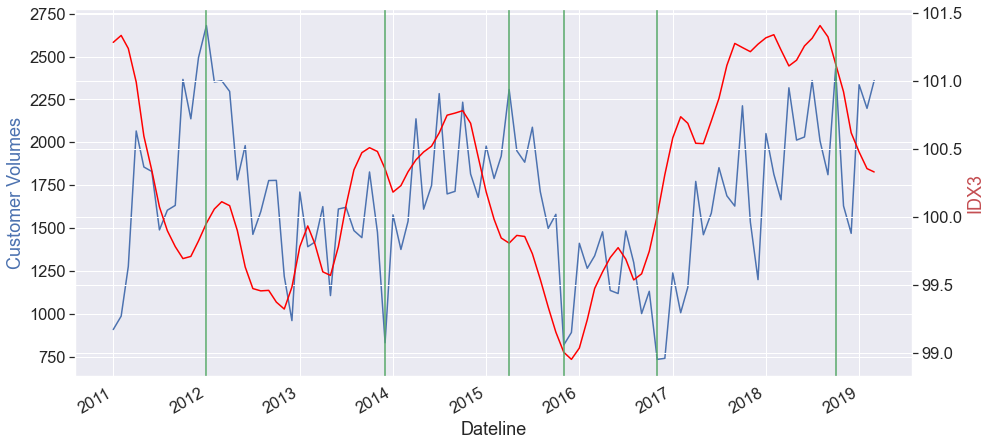

In [11]:
Series1 = "Customer Volumes"
Series2 = "IDX3"
DoLinePlot_wVLines()

### Split into Train and Test

In [12]:
n_obs=18

df_train, df_test = df[0:-n_obs], df[-n_obs:]
print(df_train.shape, df_test.shape)

(81, 4) (18, 4)


### ADF Staionary Test

In [13]:
### 1. ADF statistic less than several critical values
### 2. P-Value less than 0.05

In [14]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [15]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1179
 No. Lags Chosen       = 12
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0253. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1394
 No. Lags Chosen       = 1
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.6991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

###  First order difference transoform

Clearly, our series are non stationary, so let's go ahead and use the first order difference method and check if they are stationary

In [16]:
df_differenced = df_train.diff().dropna()

In [17]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9075
 No. Lags Chosen       = 11
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0445. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1381
 No. Lags Chosen       = 0
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

It looks like the first order difference worked to make our time series stationary. Let's move to seeing which indicators are leading using granger's causality test

### Granger Causality test

We want to identify if any of the indices are leading indicators. A quick visual plot showed that Index 3 has peaks and troughs that clearly lead the peaks and troughs in the customer volume. 

Let's dig in deeper and do an actual statistical test to see which of the indices can be used to predict customer volumes. 

Granger's Causality Test is used to confirm or deny if one time series can be used to predict another time series. Any time series that has a p-value less than the level of significance satisty the properties of causality - the feature must be be leading the target variable, the magnitude of change in the feature corresponds to a proportional level of change in the target, etc. 

In our case we want to see if indices 1, 2 and 3 can be used to predict customer volume.

Granger's causality test requires:

* the input time series to be stationary

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=13
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)  

,Customer Volumes_x,IDX1_x,IDX2_x,IDX3_x
Customer Volumes_y,1.0000,0.0011,0.1937,0.0113
IDX1_y,0.1348,1.0000,0.0334,0.0004
IDX2_y,0.6241,0.0010,1.0000,0.0003
IDX3_y,0.0004,0.0820,0.0001,1.0000


From the results of the grangers causality test, we can clearly see that the idx1 and idx3 can be used as leading indicators to predict customer volumes for a maximum lag of 6 months because their p-values are less than the level of significance = 0.05 . 

### Cointegration Test

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Customer Volumes ::  73.95     > 40.1749   =>   True
IDX1   ::  35.54     > 24.2761   =>   True
IDX2   ::  19.3      > 12.3212   =>   True
IDX3   ::  5.95      > 4.1296    =>   True


### Select the Order (P) of VAR model

In [20]:
df_differenced = df_differenced[['Customer Volumes','IDX1','IDX3']]

In [21]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  10.386755538932084
BIC :  10.746671668420746
FPE :  32435.71966640182
HQIC:  10.530948952068744 

Lag Order = 2
AIC :  9.800789089846907
BIC :  10.43528762010949
FPE :  18074.21633388916
HQIC:  10.05479050618133 

Lag Order = 3
AIC :  9.65092973835701
BIC :  10.564100681936369
FPE :  15605.13735928204
HQIC:  10.016190093606987 

Lag Order = 4
AIC :  9.64186623744201
BIC :  10.83790045153631
FPE :  15553.724054816012
HQIC:  10.119859361724876 

Lag Order = 5
AIC :  9.774936108989381
BIC :  11.258128501652621
FPE :  17942.048169015667
HQIC:  10.36715854475957 

Lag Order = 6
AIC :  9.589716315032712
BIC :  11.364469157095384
FPE :  15138.170763437536
HQIC:  10.297687043626176 

Lag Order = 7
AIC :  9.696625437706592
BIC :  11.767451781758563
FPE :  17232.631337882744
HQIC:  10.521885501293657 

Lag Order = 8
AIC :  9.705071315167974
BIC :  12.076598522476363
FPE :  17951.484854863953
HQIC:  10.649183319134526 

Lag Order = 9
AIC :  9.703460609646799
BIC :  12.3804339

In [22]:
x = model.select_order(maxlags=13)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.08,11.17,6.457e+04,11.11
1,10.24,10.63,2.792e+04,10.39
2,9.513,10.20*,1.356e+04,9.786*
3,9.446,10.43,1.274e+04*,9.837
4,9.441,10.72,1.279e+04,9.949
5,9.631,11.21,1.567e+04,10.26
6,9.707,11.58,1.724e+04,10.45
7,9.629,11.80,1.639e+04,10.49
8,9.541,12.01,1.560e+04,10.52
9,9.489,12.25,1.556e+04,10.58


### 1. Var Model

### Train the VAR Model of Selected Order(p)

In [23]:
model_fitted = model.fit(13)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Jul, 2021
Time:                     14:07:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.3264
Nobs:                     67.0000    HQIC:                   10.9402
Log likelihood:          -479.359    FPE:                    20466.9
AIC:                      9.37768    Det(Omega_mle):         5024.87
--------------------------------------------------------------------
Results for equation Customer Volumes
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                      -51.914525        48.829514           -1.063           0.288
L1.Customer Volumes         -0.334685         0.181148           -1.848           0.065
L1.IDX1              

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [24]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ':', round(val, 2))


Customer Volumes : 1.97
IDX1 : 2.18
IDX3 : 1.87


### Forecast VAR model using statsmodels

In [25]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

13


array([[-2.98000000e+02,  1.66666667e-01,  4.51100000e-02],
       [ 1.30000000e+02,  4.25000000e+00,  1.65820000e-01],
       [-3.97000000e+02, -4.03333333e+00,  2.61770000e-01],
       [ 6.00000000e+00,  7.36000000e+00,  3.03000000e-01],
       [ 4.98000000e+02,  9.70000000e-01,  2.70400000e-01],
       [-2.32000000e+02,  7.63333333e-01,  1.55400000e-01],
       [ 1.49000000e+02, -3.45000000e+00, -4.83000000e-02],
       [ 6.17000000e+02,  1.26000000e+00, -1.46900000e-01],
       [-3.11000000e+02, -2.27000000e+00, -2.60000000e-03],
       [ 1.26000000e+02, -3.72666667e+00,  1.66600000e-01],
       [ 2.65000000e+02,  1.49000000e+00,  1.66400000e-01],
       [-1.64000000e+02,  2.28666667e+00,  2.42900000e-01],
       [-6.00000000e+01,  3.00666667e+00,  1.61800000e-01]])

In [26]:
df_selected = df[['Customer Volumes','IDX1','IDX3']]

In [27]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=n_obs)
df_forecast = pd.DataFrame(fc, index=df_selected.index[-n_obs:], columns=df_selected.columns + '_pred')
df_forecast

,Customer Volumes_pred,IDX1_pred,IDX3_pred
Month,,,
2017-10-01,384.805607,-11.382315,-0.008836
2017-11-01,-437.786837,-10.186532,-0.216428
2017-12-01,-27.597831,-5.219113,-0.292797
2018-01-01,483.310200,-4.218701,-0.258670
2018-02-01,-327.594337,-3.199339,-0.094856
2018-03-01,208.650708,-0.428344,-0.046078
2018-04-01,269.036879,-0.369242,0.017514
2018-05-01,-572.222375,2.555019,0.078183
2018-06-01,129.335641,-4.344196,0.057294


In [28]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_pred'].cumsum()
    return df_fc

In [29]:
df_results = invert_transformation(df_train[['Customer Volumes','IDX1','IDX3']], df_forecast)

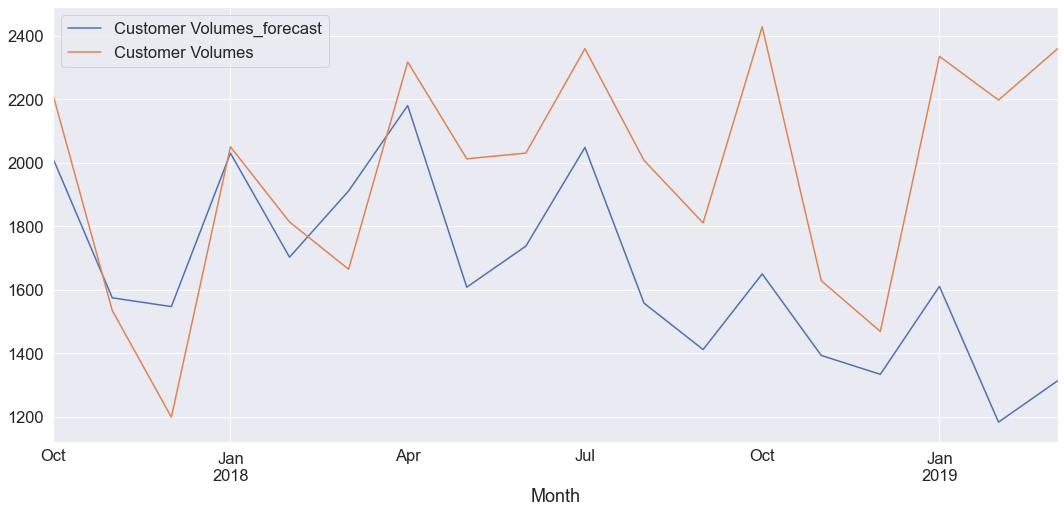

In [30]:
df_results['Customer Volumes'+'_forecast'].plot(legend=True)
df_test['Customer Volumes'][-n_obs:].plot(legend=True)
ax.set_title('Customer Volumes' + ": Forecast vs Actuals")
plt.show()

### Evaluate

In [31]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): 
        return str(val).ljust(length)
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(df_results['Customer Volumes_forecast'].values, df_test['Customer Volumes'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.1877
me     :  -312.5384
mae    :  383.1192
mpe    :  -0.1361
rmse   :  488.3598
corr   :  0.2968
minmax :  0.183


### 2. fbprophet

In [32]:
import itertools
from prophet import Prophet

In [33]:
# prepare data for fbprophet model
df = df.reset_index()
df.columns = ['ds', 'y', 'IDX1', 'IDX2', 'IDX3']

In [34]:
df_fb = df.copy()
df_fb.head()

,ds,y,IDX1,IDX2,IDX3
0,2011-01-01,908.0,92.690595,108.008014,101.2842
1,2011-02-01,986.0,97.914192,102.123691,101.3352
2,2011-03-01,1276.0,108.645217,101.238374,101.2392
3,2011-04-01,2066.0,116.243167,109.568848,100.9917
4,2011-05-01,1856.0,108.068513,110.511852,100.5940


In [35]:
df.head()
df.columns =['ds', 'y', 'IDX1', 'IDX2', 'IDX3']
future_idx1 = indexes['IDX1'].reset_index(drop=True)
future_idx3 =indexes['IDX3'].reset_index(drop=True)

df=df.dropna(how='any')
df=df.reset_index(drop=True)
df.tail()

,ds,y,IDX1,IDX2,IDX3
94,2018-11-01,1629.0,62.316667,97.431685,100.9204
95,2018-12-01,1469.0,53.960000,94.062920,100.6184
96,2019-01-01,2336.0,56.583333,80.055366,100.4775
97,2019-02-01,2198.0,61.133333,69.545042,100.3547
98,2019-03-01,2360.0,63.786667,68.259255,100.3300


In [36]:
m = Prophet(growth='linear',
            seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            weekly_seasonality=False
            ).add_seasonality(
                name = 'quarterly',
                period = 120,
                fourier_order = 15
            )
            
m.add_regressor('IDX1')
m.add_regressor('IDX3')

In [37]:
m.fit(df)
future = m.make_future_dataframe(periods=18, freq = 'MS')
future['IDX1']=future_idx1
# future['IDX2']=future_idx2
future['IDX3']=future_idx3


Initial log joint probability = -210.767
Iteration  1. Log joint probability =    54.5203. Improved by 265.287.
Iteration  2. Log joint probability =    102.695. Improved by 48.1749.
Iteration  3. Log joint probability =    141.742. Improved by 39.0472.
Iteration  4. Log joint probability =    163.873. Improved by 22.1308.
Iteration  5. Log joint probability =    163.932. Improved by 0.0587897.
Iteration  6. Log joint probability =    163.957. Improved by 0.0251581.
Iteration  7. Log joint probability =    177.136. Improved by 13.179.
Iteration  8. Log joint probability =    180.507. Improved by 3.37105.
Iteration  9. Log joint probability =    180.529. Improved by 0.021531.
Iteration 10. Log joint probability =    181.018. Improved by 0.489361.
Iteration 11. Log joint probability =    181.029. Improved by 0.0110762.
Iteration 12. Log joint probability =    181.062. Improved by 0.0325575.
Iteration 13. Log joint probability =    181.108. Improved by 0.0460591.
Iteration 14. Log joint 

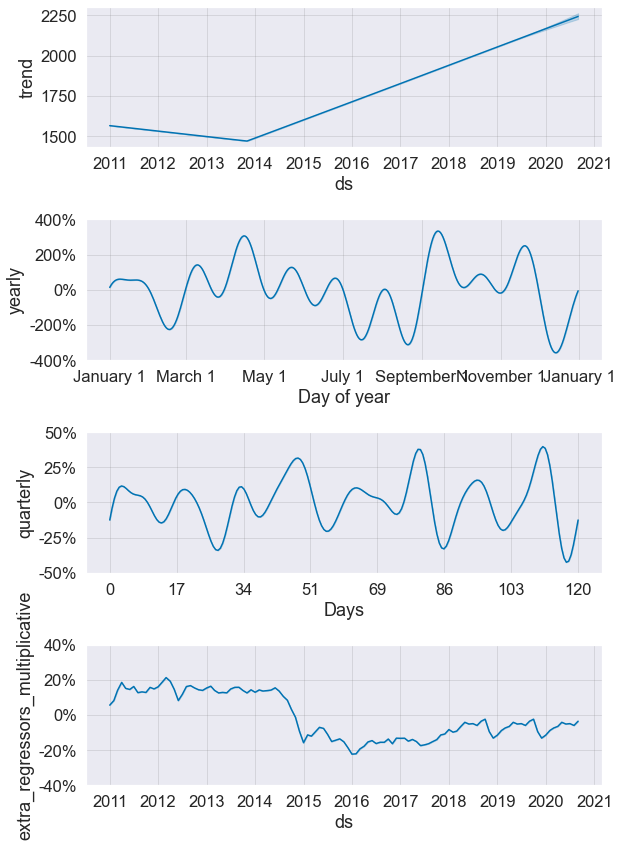

In [38]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

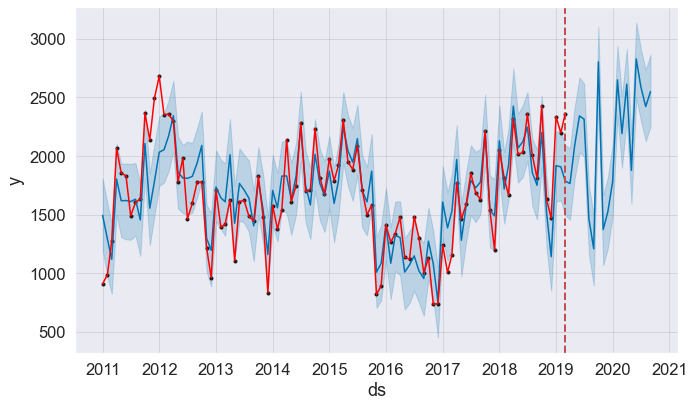

In [39]:
fig = m.plot(forecast, uncertainty=True)
plt.axvline(df['ds'].iloc[df.shape[0]-1], color='r', linestyle='--', lw=2)
plt.plot(df['ds'], df['y'], color="red" )

In [40]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [41]:
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(metric_df.yhat.values, metric_df.y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.1216
me     :  0.7564
mae    :  183.9064
mpe    :  0.0264
rmse   :  236.4885
corr   :  0.8439
minmax :  0.1069
